In [1]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from scoring_tables import make_table
from twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from reliability_diagram import make_reliability_diagram

2024-03-07 15:54:44.040822: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 15:54:44.067560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 15:54:44.067593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 15:54:44.068351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 15:54:44.072568: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 15:54:44.073054: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
neighbourhood_size = 11
parameter_names = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']
ignore = ['229', '285', '323']
train_folds = [1, 2]
train_data = get_normalized_tensor(neighbourhood_size, parameter_names, train_folds, ignore)

X_train = train_data['X']
y_train = train_data['y']
variances_train = train_data['variances']
mean_train = train_data['mean']
std_train = train_data['std']


print(X_train.shape)

(15733, 5)


In [3]:
test_fold = 3

X_test, y_test, variances_test = get_tensors(neighbourhood_size, parameter_names, test_fold, ignore)
X_test = (X_test - mean_train) / std_train

print(X_test.shape)

(7780, 5)


In [4]:
# load the dictionary with the data from /net/pc200239/nobackup/users/hakvoort/models
with open('/net/pc200239/nobackup/users/hakvoort/models/emos_crps.pkl', 'rb') as f:
    models_crps = pkl.load(f)

with open('/net/pc200239/nobackup/users/hakvoort/models/emos_twcrps_mean_12_std_4.pkl', 'rb') as f:
    models_twcrps_mean_12_std_4 = pkl.load(f)

with open('/net/pc200239/nobackup/users/hakvoort/models/emos_twcrps_mean_13_std_2.pkl', 'rb') as f:
    models_twcrps_mean_13_std_2 = pkl.load(f)

In [5]:
print(models_crps.keys())

dict_keys(['crps_tn', 'crps_ln', 'crps_gev', 'crps_frechet', 'crps_mix_tn_ln', 'crps_mix_tn_gev', 'crps_mix_tn_frechet', 'crps_mixlinear_tn_ln', 'crps_mixlinear_tn_gev', 'crps_mixlinear_tn_frechet'])


In [6]:
tn_crps = EMOS(models_crps['crps_tn'])
tn_twcrps_mean_12_std_4 = EMOS(models_twcrps_mean_12_std_4['twcrps_tn'])
tn_twcrps_mean_13_std_2 = EMOS(models_twcrps_mean_13_std_2['twcrps_tn'])

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [7]:
crps_models = {'tn': tn_crps, 'twcrps_mean_12_std_4': tn_twcrps_mean_12_std_4, 'twcrps_mean_13_std_2': tn_twcrps_mean_13_std_2}


There are 1568 values in the PIT diagram


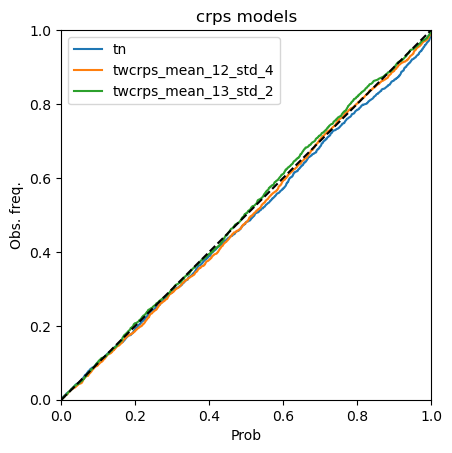

In [8]:
c= 8
make_cpit_diagram_emos(crps_models, X_test, y_test, variances_test, "crps models", c)




In [18]:
samples = 2000

for key, model in crps_models.items():
    print("CRPS: ", key, model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

threshold_list = [10, 12, 14, 16]

for threshold in threshold_list:
    for key, model in crps_models.items():
        print("twCRPS with threshold ", threshold, ":", key, model.loss_twCRPS_indicator_sample(X_test, y_test, variances_test, threshold, samples).numpy())

CRPS:  twcrps_mean_12_std_4 0.89943683
CRPS:  twcrps_mean_13_std_2 0.9388841
CRPS:  tn 0.8907235
twCRPS with threshold  10 : twcrps_mean_12_std_4 0.1319003
twCRPS with threshold  10 : twcrps_mean_13_std_2 0.13230316
twCRPS with threshold  10 : tn 0.13229662
twCRPS with threshold  12 : twcrps_mean_12_std_4 0.06323848
twCRPS with threshold  12 : twcrps_mean_13_std_2 0.062766604
twCRPS with threshold  12 : tn 0.06414137
twCRPS with threshold  14 : twcrps_mean_12_std_4 0.025185134
twCRPS with threshold  14 : twcrps_mean_13_std_2 0.025080362
twCRPS with threshold  14 : tn 0.025866559
twCRPS with threshold  16 : twcrps_mean_12_std_4 0.007973575
twCRPS with threshold  16 : twcrps_mean_13_std_2 0.0078635365
twCRPS with threshold  16 : tn 0.008330603


In [10]:
base_model = crps_models.pop('tn')

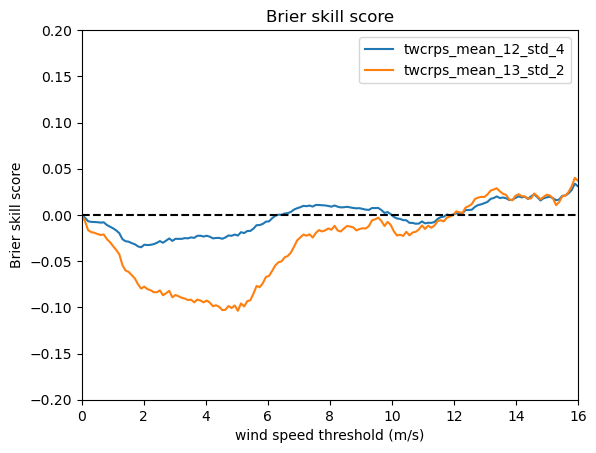

In [11]:
values = np.linspace(0,16, 160)
ylim = [-0.2, 0.2]
brier_skill_plot(base_model, crps_models, X_test, y_test, variances_test, values, ylim)

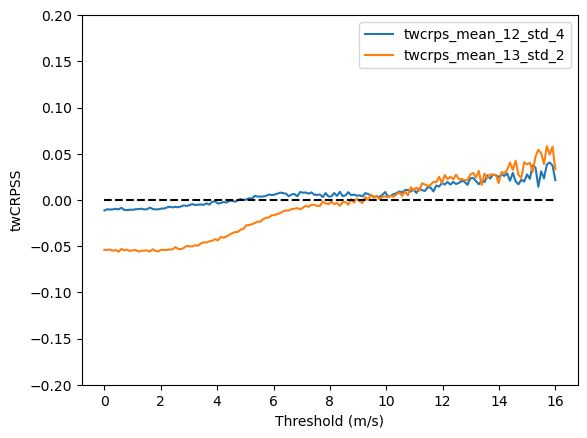

In [12]:
make_twcrpss_plot(base_model, crps_models, X_test, y_test, variances_test, values, ylim)

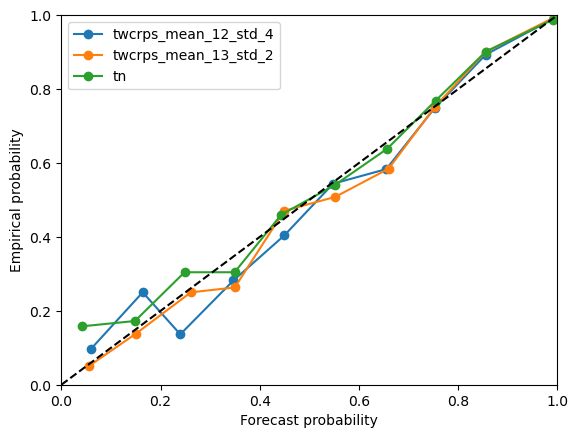

In [17]:
crps_models['tn'] = base_model

make_reliability_diagram(crps_models, X_test, y_test, variances_test, 13)